# Gaussain Processes From Scratch

## Intuitions
We are given samples from an unknown process. A process is the underlying mechanism that generates a measured signal.

GPs provide a way to regress these points (fit a curve) and provide uncertainty/confidence estimates throughout the domain of the regressed curve.

**At a high level, GPs are a distribution over functions.**

Technically, GPs are the infinite dimensional generalization of the multi-variate Gaussian distribution.

A function can be represented as a infinite dimensional vector. Then a GP can be interpreted as a distribution over infinite dimensional vectors. 

For practical purposes, we use the finite dimensional representation -- which is still jointly Gaussian.

## Math
$f$ ~ $GP(m, k)$

where $m$ is a mean fn. Denotes the a priori expectation of the unknown process. Typically set at 0.

$m(x) = E[f(x)]$

$K$ is the covariance or kernel fn. Measures how 'similar' or 'related' $f(x)$ and $f(x')$ are.

Must be a symmetric fn, i.e. $K(x, x') = K(x', x)$. Typically a Gaussian Kernel, aka square exponential, RBF.

$K(x, x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$

Use the kernel function to form the covariance matrix.

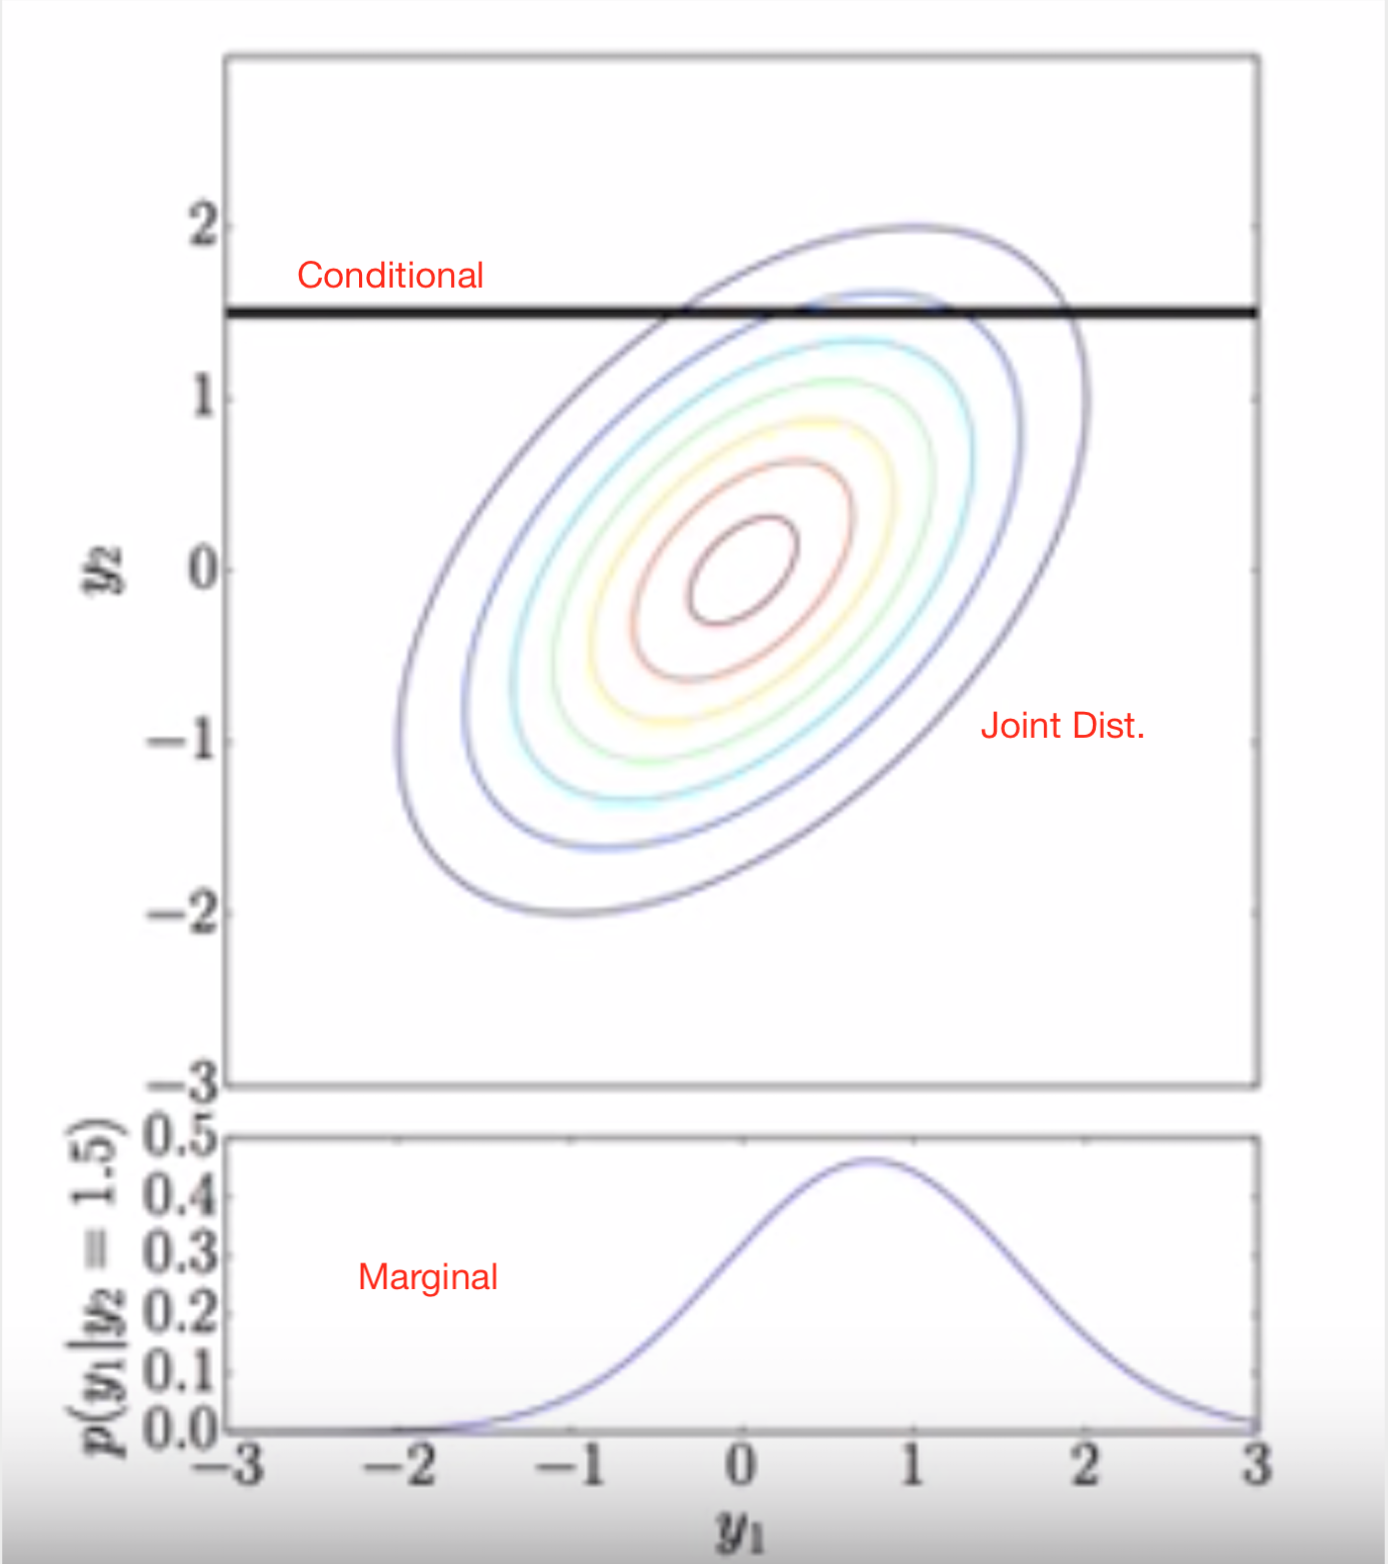
(from https://www.youtube.com/watch?v=rTZPfF8PoIs&list=PLR6O_WZHBlOGlq9GiYjCZb4nQbqsT11Pl&index=2)

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Sampling from a multi-variate Gaussian

Take $D$ samples from $N(0,1)$ to form the vector $v$

In [59]:
def draw_std_norm_samples(d):
    return np.array([np.random.normal() for i in range(d)])

D = 10
v = draw_std_norm_samples(D)
v

array([ 1.15072883,  0.92084209,  1.13910227, -0.25036428,  1.8762209 ,
       -0.82419363,  0.02320127,  0.79405621, -1.08572624, -0.56621211])

(array([2., 1., 1., 1., 0., 0., 2., 2., 0., 1.]),
 array([-1.08572624, -0.78953153, -0.49333682, -0.1971421 ,  0.09905261,
         0.39524733,  0.69144204,  0.98763676,  1.28383147,  1.58002619,
         1.8762209 ]),
 <a list of 10 Patch objects>)

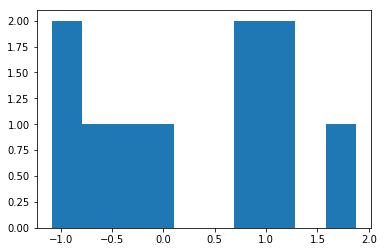

In [60]:
plt.hist(v)

Generate a covariance matrix $\Sigma$ of shape D x D

In [61]:
Cov = np.zeros((2,2), dtype=np.int)
Cov[0, 0] = 3
Cov[1, 1] = 3
Cov[0, 1] = 1
Cov[1, 0] = 1
Cov

array([[3, 1],
       [1, 3]])

In [62]:
Cov = np.eye(D, dtype=np.int) * 3
for i in range(1, D):
    Cov[i-1, i] = 1
for i in range(D-1):
    Cov[i+1, i] = 1
Cov

array([[3, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 3, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 3, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 3, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 3, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 3, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 3, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 3, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 3, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 3]])

Cholesky Decomposition of $\Sigma$

In [63]:
np.linalg.eigvalsh(Cov)

array([1.08101405, 1.31749293, 1.69027853, 2.16916997, 2.71537032,
       3.28462968, 3.83083003, 4.30972147, 4.68250707, 4.91898595])

In [64]:
L = np.linalg.cholesky(Cov)
assert np.allclose(L @ L.transpose(), Cov)
L

array([[1.73205081, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.57735027, 1.63299316, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.61237244, 1.62018517, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.6172134 , 1.61834719, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.61791438, 1.61807967,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.61801654,
        1.61804065, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.61803144, 1.61803496, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

$y = \mu + L * v$

$y$ ~ $N(\mu, \Sigma)$

In [65]:
L.shape, v.shape

((10, 10), (10,))

In [66]:
u = np.zeros(D, dtype=np.int)
y = u + L @ v
y

array([ 1.9931208 ,  2.16810243,  2.40945492,  0.29789286,  2.88117121,
       -0.17404325, -0.47183711,  1.29914922, -1.2659883 , -1.58716616])

# Fitting a GP

1. Choose a kernel function $K(.)$.
2. Form the covariance matrix $\Sigma$ by computing K() for each entry. $\Sigma$ will be symmetric.
3. Normalize the data by subtracting the mean. Retain the original data mean as $\mu$.

Gaussian Kernel:
$K(x, x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$

In [77]:
def gaussian_kernel(x, x_, sigma=1):
    return np.exp(-1 * np.abs(x - x_) / (2*np.square(sigma)))

kernel = gaussian_kernel

def form_covariance_matrix(data, kernel_fn=kernel):
    """ Forms a covariance matrix, shape=(d,d), where d = elements in data.
    Each entry is formed by evaluating kernel_fn()
    """
    d = data.shape[0]
    cov = np.zeros((d, d))
    for row in range(d):
        for col in range(d):
            cov[row, col] = kernel_fn(data[row], data[col])
    return cov

sigma = form_covariance_matrix(y)
assert sigma.shape == (D, D)
sigma.shape, sigma

((10, 10), array([[1.        , 0.91622728, 0.81207136, 0.42843598, 0.64144925,
         0.33838126, 0.2915689 , 0.70681537, 0.19601687, 0.16693622],
        [0.91622728, 1.        , 0.88632087, 0.39254473, 0.70009839,
         0.31003415, 0.26714338, 0.64760353, 0.179596  , 0.15295152],
        [0.81207136, 0.88632087, 1.        , 0.34792059, 0.78989271,
         0.27478973, 0.23677475, 0.57398452, 0.15917969, 0.13556412],
        [0.42843598, 0.39254473, 0.34792059, 1.        , 0.27481994,
         0.7898059 , 0.68054251, 0.60614977, 0.4575173 , 0.38964099],
        [0.64144925, 0.70009839, 0.78989271, 0.27481994, 1.        ,
         0.21705441, 0.18702665, 0.45338619, 0.12573487, 0.10708111],
        [0.33838126, 0.31003415, 0.27478973, 0.7898059 , 0.21705441,
         1.        , 0.86165792, 0.47874067, 0.57927814, 0.49333765],
        [0.2915689 , 0.26714338, 0.23677475, 0.68054251, 0.18702665,
         0.86165792, 1.        , 0.41251069, 0.6722832 , 0.57254467],
        [0.706815

## Sampling from a GP (prior)

### Steps
1. Fit the GP to some given data, resulting in the covariance matrix $\Sigma$.
2. Do the Cholesky decomposition: $\Sigma = L * L'$
3. Discretize the domain into a D dim vector.
4. Form $v$ by drawing D samples from N(0, 1).
5. Compute the mean vector $\mu$ for all points in $v$
6. Compute $y = \mu + L*v$

$y$ is now a Dx1 vector of points representing **a single function sample, sampled from the GP.**

In [87]:
def draw_sample_from_GP_prior(sigma, mu=None):
    D = sigma.shape[0]
    L = np.linalg.cholesky(sigma)
    v = draw_std_norm_samples(D)
    mu_vector = mu if mu is not None else np.zeros(D)
    y = mu_vector + L @ v
    return y

In [88]:
# sigma already computed
y = draw_sample_from_GP_prior(sigma)
y

array([ 0.21426498,  1.12364353,  0.75909147,  0.3361228 , -0.0302057 ,
        0.29233416, -0.29588935, -0.23370386,  0.27258067,  0.4973215 ])

Draw 15 samples from the prior:

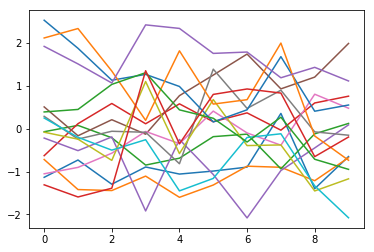

In [91]:
samples = [draw_sample_from_GP_prior(sigma) for i in range(15)]
for sample in samples:
    plt.plot(sample)

## Sampling from a GP noise free (inference)

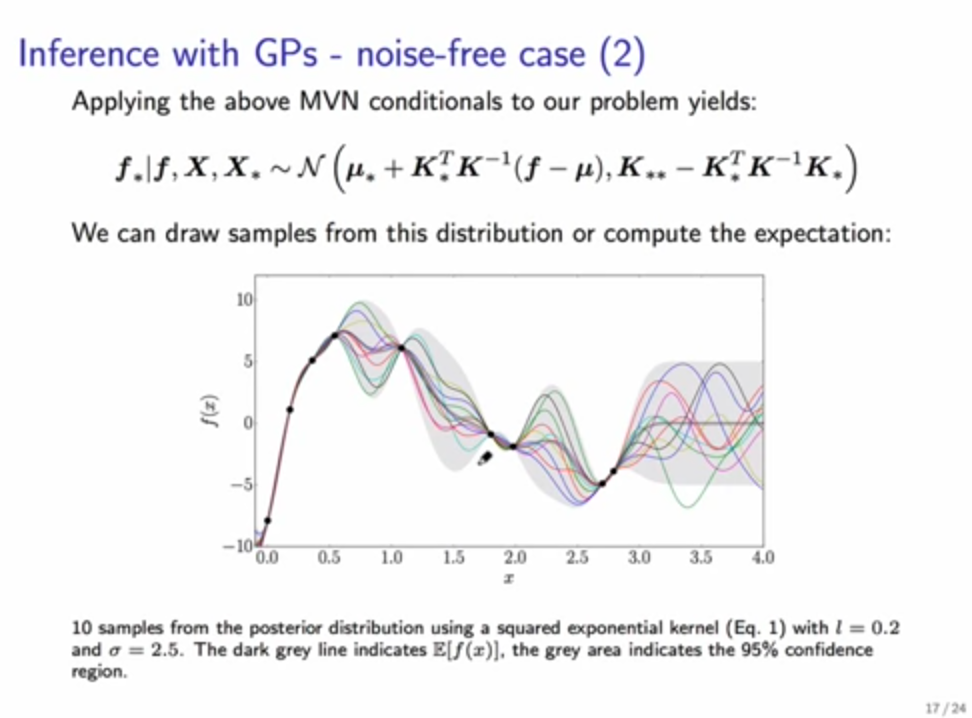

## Sampling from a GP w/ noise (inference)

In [31]:
# TODO

# References
- [A great short video series on GPs](https://www.youtube.com/watch?v=9hKfsuoFdeQ&list=PLR6O_WZHBlOGlq9GiYjCZb4nQbqsT11Pl&index=1)